/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


(<Figure size 900x1000 with 1 Axes>, <Axes: >)

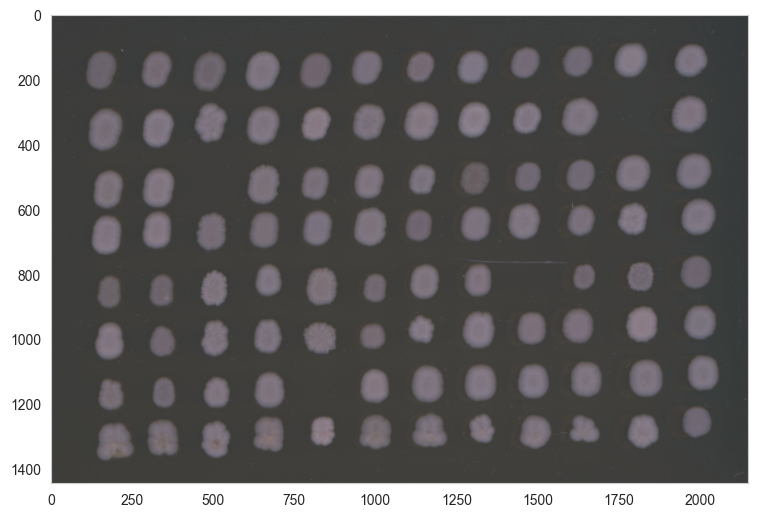

In [1]:
from phenotypic import GridImage

from phenotypic.data import load_plate_72hr

plate_image = GridImage(load_plate_72hr(), name='Plate72Hr')
plate_image.show()

In [2]:
from pympler import asizeof

print(f'Array size: {asizeof.asizeof(load_plate_72hr()) / 1000000} mbytes')
print(f'Phenotypic.GridImage: {asizeof.asizeof(plate_image) / 1000000} mbytes')
print(f'Ratio: {asizeof.asizeof(plate_image) / asizeof.asizeof(load_plate_72hr())}')

Array size: 9.31396 mbytes
Phenotypic.GridImage: 21.748768 mbytes
Ratio: 2.3350720853428615


In [3]:
total_data_footprint = 0
for data_key, data_value in plate_image._data.__dict__.items():
    print(
        f'{data_key} | {data_value.dtype}: {asizeof.asizeof(data_value) / 1000000} mbytes | shape: {data_value.shape} | fold-increase: {asizeof.asizeof(data_value) / asizeof.asizeof(load_plate_72hr())}')
    total_data_footprint += asizeof.asizeof(data_value)
print(f'Total data footprint: {total_data_footprint / 1000000} mbytes')
print(f'Class overhead: {asizeof.asizeof(plate_image) / 1000000 - total_data_footprint / 1000000}')

array | uint8: 9.31396 mbytes | shape: (1444, 2150, 3) | fold-increase: 1.0
matrix | uint16: 6.20936 mbytes | shape: (1444, 2150) | fold-increase: 0.6666723928382772
enh_matrix | uint16: 6.20936 mbytes | shape: (1444, 2150) | fold-increase: 0.6666723928382772
sparse_object_map | uint16: 0.009936 mbytes | shape: (1444, 2150) | fold-increase: 0.001066785771036165
Total data footprint: 21.742616 mbytes
Class overhead: 0.006151999999996605


/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


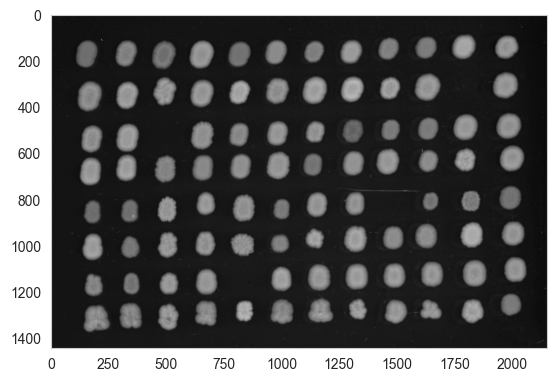

In [4]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
fig, ax = plt.subplots()
ax.grid(False)
ax.imshow(rgb2gray(plate_image.array[:]), cmap='gray')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

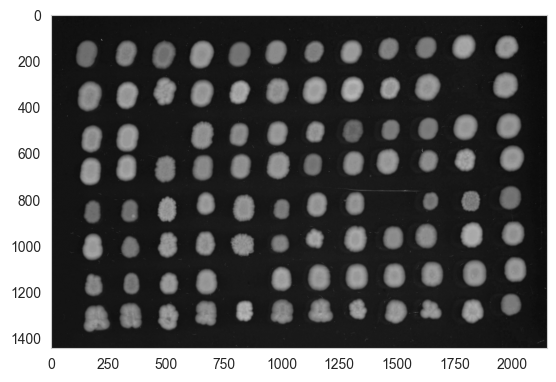

In [5]:
plate_image.matrix.show()

/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


(<Figure size 900x1000 with 1 Axes>, <Axes: >)

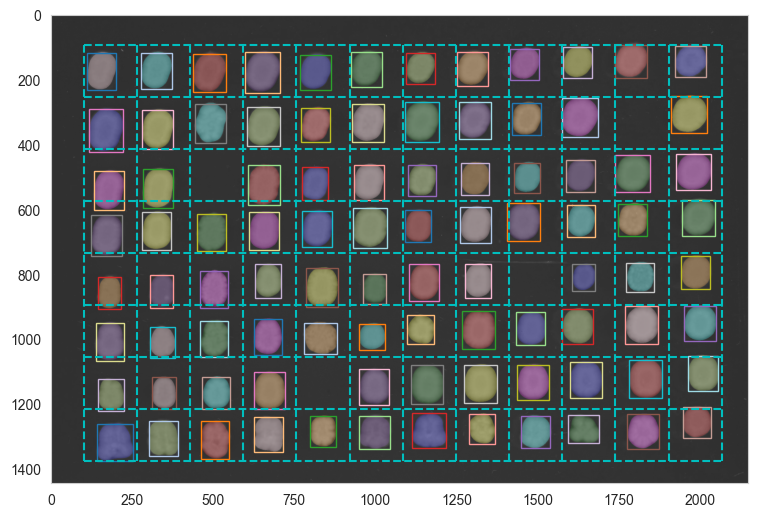

In [6]:
from phenotypic.pipeline import ImagePipeline
from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
from phenotypic.detection import WatershedDetector
from phenotypic.grid import GridAligner, GridApply, MinResidualErrorReducer, LinRegResidualOutlierRemover
from phenotypic.objects import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover

from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture

kmarx_pipeline = ImagePipeline(
    op_queue={
        'blur': GaussianSmoother(sigma=10),
        'clahe': CLAHE(),
        'median filter': MedianEnhancer(),
        'detection': WatershedDetector(footprint='auto')},

    measurement_queue={
        'MeasureColor': MeasureColor(),
        'MeasureShape': MeasureShape(),
        'MeasureIntensity': MeasureIntensity(),
        'MeasureTexture': MeasureTexture()}
)

pipeline_output = kmarx_pipeline.apply(plate_image)
pipeline_output.objects.relabel()
pipeline_output.show_overlay()



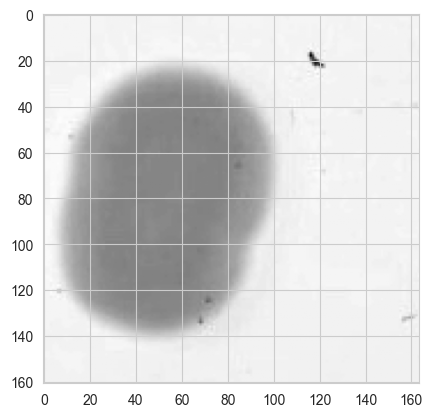

In [7]:
colony_image = pipeline_output.grid[0]
from skimage.util import invert
colony_matrix = invert(colony_image.matrix[:])

import matplotlib.pyplot as plt
plt.imshow(colony_matrix, cmap='gray')

In [8]:
pipeline_output.save2hdf5('./example_phenotypic_hdf5.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [9]:
test_hdf5_load = GridImage.load_hdf5('./example_phenotypic_hdf5.h5', image_name='Plate72Hr' )
test_hdf5_load.show()

EmptyImageError: No _parent_image data loaded. Use Image.set_image(new_image) to load data.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

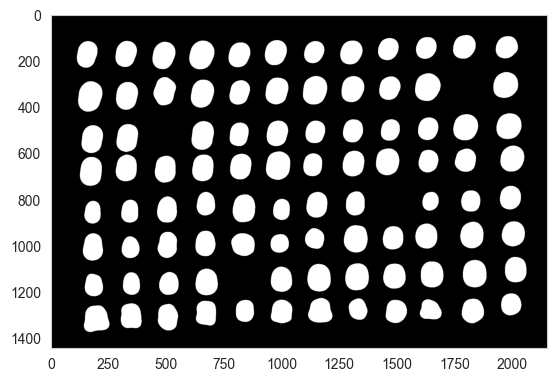

In [23]:
pipeline_output.objmask.show()

In [24]:
# from phenotypic.pipeline import ImagePipeline
# from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
# from phenotypic.detection import OtsuDetector
# from phenotypic.grid import GridAligner, GridApply, MinResidualErrorReducer, LinRegResidualOutlierRemover
# from phenotypic.objects import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover
#
# from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture
#
# kmarx_pipeline = ImagePipeline(
#     op_queue={
#         'blur': GaussianSmoother(sigma=10),
#         'clahe': CLAHE(),
#         'median filter': MedianEnhancer(),
#         'detection': OtsuDetector(),
#         'border_removal': BorderObjectRemover(50),
#         'low circularity remover': LowCircularityRemover(0.6),
#         'small object remover': SmallObjectRemover(100),
#         'Reduce by section residual error': MinResidualErrorReducer(),
#         'outlier removal': LinRegResidualOutlierRemover(),
#         'align': GridAligner(),
#         'section-level detect': GridApply(ImagePipeline({
#             'blur': GaussianSmoother(sigma=5),
#             'median filter': MedianEnhancer(),
#             'contrast stretching': ContrastStretching(),
#             'detection': OtsuDetector(),
#         }
#         )
#         ),
#         'small object remover 2': SmallObjectRemover(100),
#         'grid_reduction': MinResidualErrorReducer()
#     },
#     measurement_queue={
#         'MeasureColor': MeasureColor(),
#         'MeasureShape': MeasureShape(),
#         'MeasureIntensity': MeasureIntensity(),
#         'MeasureTexture': MeasureTexture()}
# )
#
# pipeline_output = kmarx_pipeline.apply(plate_image)
# pipeline_output.show_overlay()
#


In [25]:
shape_measurements = MeasureShape().measure(pipeline_output)
shape_measurements

,Shape_Area,Shape_Perimeter,Shape_Circularity,Shape_ConvexArea,Shape_Orientation,Shape_MedianRadius,Shape_MeanRadius,Shape_Eccentricity,Shape_Solidity,Shape_Extent,Shape_BboxArea,Shape_MajorAxisLength,Shape_MinorAxisLength,Shape_Compactness
ObjectLabel,,,,,,,,,,,,,,
1,7989.0,332.149278,0.909988,317.681253,0.0,14.866069,16.801193,0.504495,25.147848,0.799220,9996.0,108.577225,93.747169,1.098916
2,7272.0,316.149278,0.914280,302.796940,0.0,14.142136,16.082054,0.475021,24.016095,0.789062,9216.0,102.624626,90.307027,1.093757
3,6685.0,304.007143,0.908958,290.148037,0.0,13.601471,15.430387,0.496210,23.039963,0.799068,8366.0,99.030916,85.978898,1.100161
4,6765.0,306.249783,0.906413,292.227492,0.0,13.601471,15.462370,0.523953,23.149773,0.791784,8544.0,100.581933,85.670376,1.103250
5,8213.0,338.977705,0.898192,323.033129,0.0,15.000000,16.909651,0.565759,25.424637,0.792149,10368.0,112.654492,92.891601,1.113347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,7422.0,321.421356,0.902779,306.812056,0.0,14.212670,16.119033,0.448755,24.190705,0.806739,9200.0,103.027942,92.071413,1.107691
89,8002.0,339.722871,0.871282,326.060899,0.0,14.317821,16.011804,0.579137,24.541428,0.859598,9309.0,112.597343,91.792766,1.147734
90,8332.0,345.379726,0.877739,331.272715,0.0,14.866069,16.440955,0.568524,25.151483,0.865213,9630.0,114.278217,94.012902,1.139291


In [26]:
intensity_measurements = MeasureIntensity().measure(pipeline_output)
intensity_measurements

,Intensity_IntegratedIntensity,Intensity_MinimumIntensity,Intensity_MaximumIntensity,Intensity_MeanIntensity,Intensity_MedianIntensity,Intensity_StandardDeviationIntensity,Intensity_CoefficientVarianceIntensity,Intensity_LowerQuartileIntensity,Intensity_UpperQuartileIntensity,Intensity_InterquartileRangeIntensity
ObjectLabel,,,,,,,,,,
1,3614.147845,0.294682,0.505562,0.452391,0.473655,0.048592,0.107426,0.419593,0.492699,0.073106
2,3203.717433,0.302541,0.487633,0.440555,0.456016,0.037250,0.084564,0.419593,0.469169,0.049577
3,2658.051087,0.278431,0.429953,0.397614,0.417380,0.033693,0.084750,0.381521,0.422110,0.040589
4,2712.530755,0.261311,0.447608,0.400965,0.421546,0.041006,0.102284,0.384298,0.429374,0.045075
5,3367.238132,0.254902,0.457404,0.409989,0.437797,0.051070,0.124578,0.386252,0.448417,0.062165
...,...,...,...,...,...,...,...,...,...,...
88,3228.780636,0.283436,0.497154,0.435028,0.450660,0.043669,0.100395,0.407813,0.469703,0.061891
89,3367.402914,0.264424,0.483619,0.420820,0.431876,0.037897,0.090065,0.398291,0.450080,0.051789
90,3444.189761,0.254597,0.477790,0.413369,0.422629,0.035114,0.084956,0.394369,0.438315,0.043946


In [27]:
texture_measurements = MeasureTexture().measure(pipeline_output)
texture_measurements

,Texture_AngularSecondMoment-deg(0)-intensity-scale(5),Texture_AngularSecondMoment-deg(45)-intensity-scale(5),Texture_AngularSecondMoment-deg(90)-intensity-scale(5),Texture_AngularSecondMoment-deg(135)-intensity-scale(5),Texture_Contrast-deg(0)-intensity-scale(5),Texture_Contrast-deg(45)-intensity-scale(5),Texture_Contrast-deg(90)-intensity-scale(5),Texture_Contrast-deg(135)-intensity-scale(5),Texture_Correlation-deg(0)-intensity-scale(5),Texture_Correlation-deg(45)-intensity-scale(5),...,Texture_DifferenceEntropy-deg(90)-intensity-scale(5),Texture_DifferenceEntropy-deg(135)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(135)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(135)-intensity-scale(5)
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,0.014010,0.013102,0.014162,0.012984,35.796898,64.931015,32.305907,53.312141,0.855819,0.725152,...,3.513569,3.872420,-0.275495,-0.217407,-0.272686,-0.217461,0.962654,0.932282,0.961822,0.933113
2,0.010636,0.008624,0.010658,0.009385,27.532833,51.342250,30.242491,44.180353,0.804586,0.611970,...,3.443653,3.725269,-0.230022,-0.149240,-0.212964,-0.151899,0.934846,0.856305,0.923456,0.861605
3,0.042984,0.039907,0.043119,0.040924,25.151247,47.360976,27.960256,38.286562,0.776562,0.548771,...,3.067014,3.452877,-0.269832,-0.183267,-0.241780,-0.184217,0.936590,0.866280,0.920936,0.869404
4,0.013180,0.012014,0.013550,0.011963,37.979475,66.734930,36.844146,54.564687,0.765999,0.568254,...,3.359187,3.755901,-0.237391,-0.157963,-0.215209,-0.155559,0.935649,0.861977,0.921832,0.860794
5,0.018715,0.016769,0.019415,0.017204,48.740128,90.820665,46.972071,67.709707,0.813516,0.628809,...,3.392566,3.891008,-0.284708,-0.189563,-0.258149,-0.194255,0.961144,0.902256,0.950894,0.907909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.005020,0.004283,0.005385,0.004416,31.932678,51.872928,31.019822,50.932176,0.840367,0.730029,...,3.475160,3.877552,-0.256407,-0.178851,-0.238738,-0.172435,0.959813,0.909508,0.952174,0.903489
89,0.005204,0.004241,0.004916,0.004285,21.288871,43.300138,29.172441,45.541678,0.867203,0.697735,...,3.447885,3.828168,-0.256322,-0.184877,-0.230657,-0.178080,0.959144,0.913268,0.946945,0.906899
90,0.003543,0.003179,0.004162,0.003070,25.375257,40.160042,24.286657,47.113857,0.815441,0.678948,...,3.293967,3.821789,-0.219540,-0.153478,-0.226527,-0.147149,0.939734,0.879274,0.944048,0.870516


In [28]:
color_measurements =MeasureColor().measure(pipeline_output)
color_measurements

,Hue_Mean,Hue_StdDev,Hue_Median,Hue_CoefficientVariance,Saturation_Mean,Saturation_StdDev,Saturation_Median,Saturation_CoefficientVariance,Brightness_Mean,Brightness_StdDev,Brightness_Median,Brightness_CoefficientVariance
ObjectLabel,,,,,,,,,,,,
1,277.605337,31.278689,281.250000,0.112687,0.089291,0.015980,0.085271,0.178989,0.487231,0.053131,0.513725,0.109061
2,276.140732,19.650352,276.923077,0.071170,0.094717,0.014840,0.098485,0.156701,0.477314,0.042760,0.494118,0.089596
3,271.899389,45.875779,276.923077,0.168749,0.091334,0.020569,0.094828,0.225240,0.429425,0.042094,0.450980,0.098040
4,271.445471,61.397502,283.636364,0.226221,0.090101,0.020659,0.093220,0.229321,0.431415,0.048593,0.454902,0.112653
5,267.824188,72.291271,283.636364,0.269953,0.084933,0.020184,0.090164,0.237674,0.439271,0.059527,0.466667,0.135530
...,...,...,...,...,...,...,...,...,...,...,...,...
88,289.542428,58.694489,294.545455,0.202742,0.081753,0.013014,0.085271,0.159202,0.463514,0.048382,0.482353,0.104396
89,291.641349,91.954215,326.666667,0.315338,0.088592,0.020589,0.089431,0.232431,0.451303,0.045476,0.462745,0.100779
90,280.764635,95.786023,310.000000,0.341202,0.080636,0.016603,0.083333,0.205926,0.440181,0.040678,0.450980,0.092422


In [29]:
pipeline_measurements = kmarx_pipeline.measure(pipeline_output)

In [30]:
pipeline_measurements

,Hue_Mean,Hue_StdDev,Hue_Median,Hue_CoefficientVariance,Saturation_Mean,Saturation_StdDev,Saturation_Median,Saturation_CoefficientVariance,Brightness_Mean,Brightness_StdDev,...,Texture_DifferenceEntropy-deg(90)-intensity-scale(5),Texture_DifferenceEntropy-deg(135)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(135)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(135)-intensity-scale(5)
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,277.605337,31.278689,281.250000,0.112687,0.089291,0.015980,0.085271,0.178989,0.487231,0.053131,...,3.513569,3.872420,-0.275495,-0.217407,-0.272686,-0.217461,0.962654,0.932282,0.961822,0.933113
2,276.140732,19.650352,276.923077,0.071170,0.094717,0.014840,0.098485,0.156701,0.477314,0.042760,...,3.443653,3.725269,-0.230022,-0.149240,-0.212964,-0.151899,0.934846,0.856305,0.923456,0.861605
3,271.899389,45.875779,276.923077,0.168749,0.091334,0.020569,0.094828,0.225240,0.429425,0.042094,...,3.067014,3.452877,-0.269832,-0.183267,-0.241780,-0.184217,0.936590,0.866280,0.920936,0.869404
4,271.445471,61.397502,283.636364,0.226221,0.090101,0.020659,0.093220,0.229321,0.431415,0.048593,...,3.359187,3.755901,-0.237391,-0.157963,-0.215209,-0.155559,0.935649,0.861977,0.921832,0.860794
5,267.824188,72.291271,283.636364,0.269953,0.084933,0.020184,0.090164,0.237674,0.439271,0.059527,...,3.392566,3.891008,-0.284708,-0.189563,-0.258149,-0.194255,0.961144,0.902256,0.950894,0.907909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,289.542428,58.694489,294.545455,0.202742,0.081753,0.013014,0.085271,0.159202,0.463514,0.048382,...,3.475160,3.877552,-0.256407,-0.178851,-0.238738,-0.172435,0.959813,0.909508,0.952174,0.903489
89,291.641349,91.954215,326.666667,0.315338,0.088592,0.020589,0.089431,0.232431,0.451303,0.045476,...,3.447885,3.828168,-0.256322,-0.184877,-0.230657,-0.178080,0.959144,0.913268,0.946945,0.906899
90,280.764635,95.786023,310.000000,0.341202,0.080636,0.016603,0.083333,0.205926,0.440181,0.040678,...,3.293967,3.821789,-0.219540,-0.153478,-0.226527,-0.147149,0.939734,0.879274,0.944048,0.870516
